# Transportation Demand Forecasting with Granite Time Series - Prediction Intervals

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multivariate forecasts.

This example makes use of the Kaggle bike sharing [dataset](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) which contains bikes rental demand with weather and seasonal information.

## Setting Up

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here we retrieve and install a tested version of the library.

If not installed already, please run:

```
! pip install "granite-tsfm[notebooks]==v0.2.23"
```

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function. We also leverage a few components for the fine-tuning process.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.conformal import PostHocProbabilisticProcessor
from tsfm_public.toolkit.time_series_preprocessor import create_timestamps, prepare_data_splits

### Specify configuration variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [2]:
context_length = 512  # the max context length for the 512-96 model
prediction_length = 96  # the max prediction length for the 512-96 model

# Output directory for writing evaluation results.
OUT_DIR = "/tmp/ttm_results"

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Preparing the Data

### Download the data

We'll work with a [bike sharing datasety](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) available from the UCI Machine learning repository. This dataset includes the count of rental bikes between the years 2011 and 2012 in the Capital bike share system with the corresponding weather and seasonal information.

You can download the source code to a temporary directory by running the following commands. Later you can clean up any downloaded files by removing the `temp` folder.

In [3]:
%%bash
# curl https://archive.ics.uci.edu/static/public/275/$BIKE_SHARING -o $BIKE_SHARING && \
BIKE_SHARING=bike+sharing+dataset.zip
test -d temp || ( \
  mkdir -p temp && \
  cd temp && \
    wget https://archive.ics.uci.edu/static/public/275/$BIKE_SHARING -O $BIKE_SHARING && \
    unzip -o $BIKE_SHARING && \
  rm -f $BIKE_SHARING && \
  cd - \
) && ls -l temp/

total 2400
-rw-r--r--@ 1 wmgifford  staff    57569 Dec 20  2013 day.csv
-rw-r--r--@ 1 wmgifford  staff  1156736 Dec 20  2013 hour.csv
-rw-r--r--@ 1 wmgifford  staff     5607 Dec 20  2013 Readme.txt


In [4]:
DATA_FILE_PATH = "temp/hour.csv"

### Read in the data

We parse the CSV into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a UTC datetime.

In [5]:
timestamp_column = "dteday"
target_columns = ["casual", "registered", "cnt"]

# Read in the data from the downloaded file.
input_df = pd.read_csv(DATA_FILE_PATH, parse_dates=[timestamp_column])

# Fix missing hours in original dataset date column
input_df[timestamp_column] = input_df[timestamp_column] + input_df.hr.apply(lambda x: pd.Timedelta(x, unit="hr"))

# Show the last few rows of the dataset.
input_df.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31 19:00:00,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31 20:00:00,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31 21:00:00,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31 22:00:00,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31 23:00:00,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


### Plot a segment of the target series

Here we inspect a preview of the target time series.

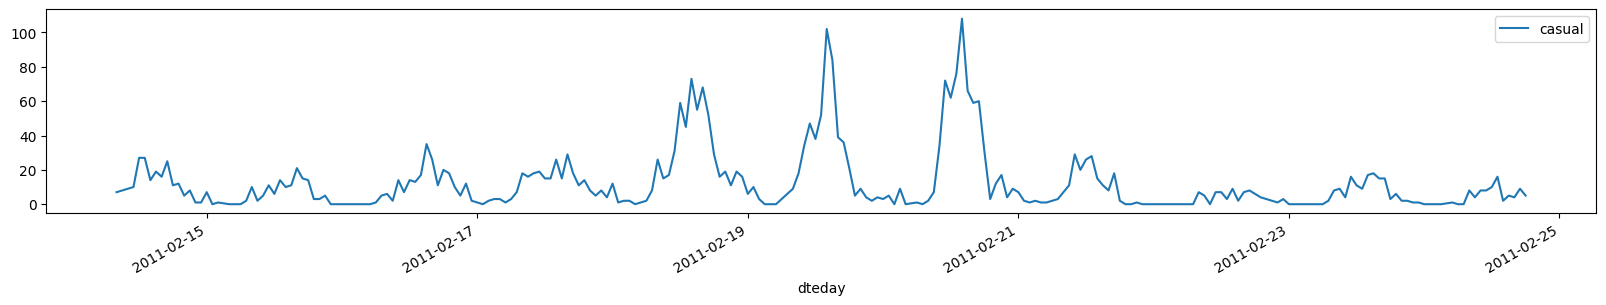

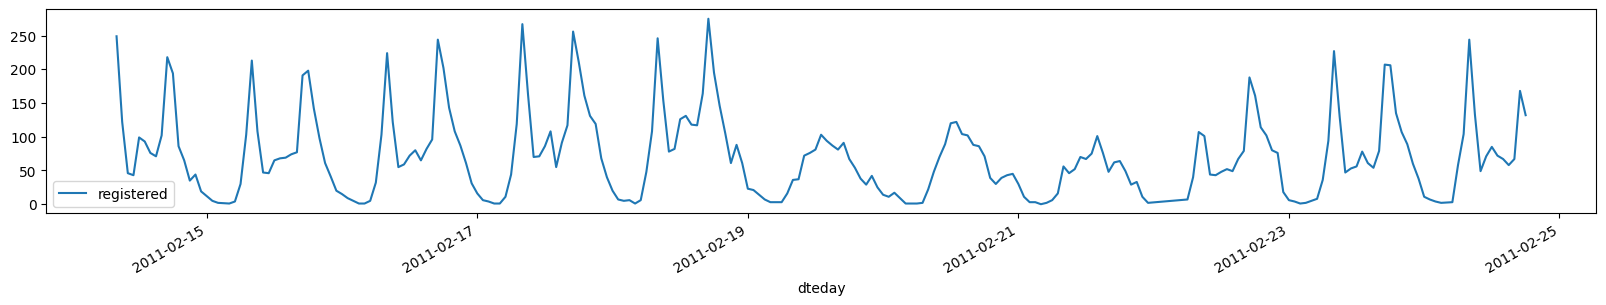

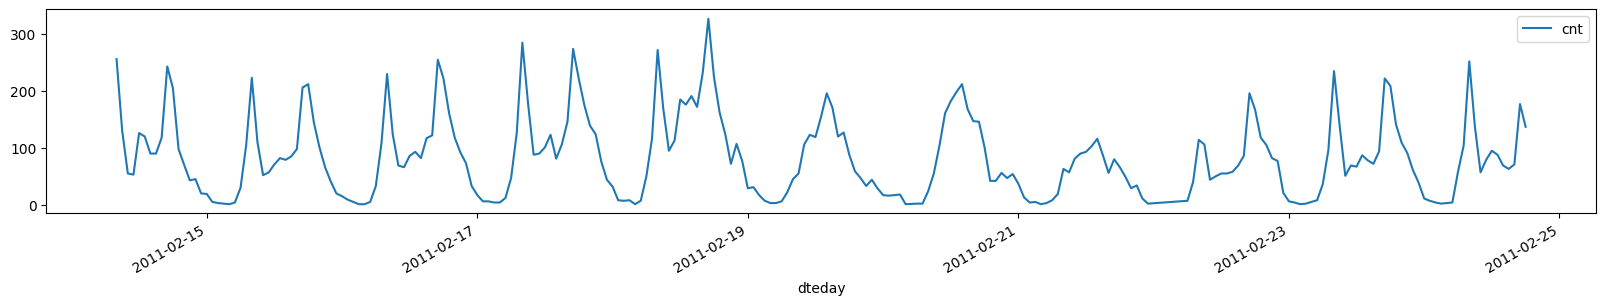

In [6]:
for target_column in target_columns:
    input_df.iloc[1000 : 1000 + 24 * 10].plot(x=timestamp_column, y=target_column, figsize=(20, 3))

## Load finetuned models

In [7]:
path = "../../../conformal/notebooks/bike_sharing_finetuned_model"
tsp = TimeSeriesPreprocessor.from_pretrained(path)
finetuned_model = TinyTimeMixerForPrediction.from_pretrained(path)

INFO:p-5268:t-8677908224:processor.py:get_feature_extractor_dict:loading configuration file ../../../conformal/notebooks/bike_sharing_finetuned_model/preprocessor_config.json


### Split the data into training, validation, and testing sets

We split the data into training, validation, and test sets. The training set is used to train the preprocessor, while the test set is used to evaluate the model performance.

In [8]:
split_config = {"train": 0.5, "test": 0.25}

train_df, valid_df, test_df = prepare_data_splits(input_df, context_length=context_length, split_config=split_config)
print(f"Data lengths: train = {len(train_df)}, val = {len(valid_df)}, test = {len(test_df)}")

Data lengths: train = 8689, val = 4858, test = 4856


### Generate forecasts on the validation dataset

In [9]:
pipeline = TimeSeriesForecastingPipeline(
    finetuned_model,
    device=device,  # Specify your local GPU or CPU.
    feature_extractor=tsp,
    batch_size=2000,
)

forecast_valid = pipeline(valid_df)

Device set to use cpu


In [10]:
# wrangle the data into the right tensors. They should have shape: num_samples x prediction_length x num_channels
prediction_columns = [f"{c}_prediction" for c in tsp.target_columns]
ground_truth_columns = tsp.target_columns
y = forecast_valid[prediction_columns].values
predictions_valid = np.array([np.stack(z) for z in y]).transpose(0, 2, 1)
predictions_valid = predictions_valid[:-prediction_length, ...]
x = forecast_valid[ground_truth_columns].values
ground_truth_valid = np.array([np.stack(z) for z in x]).transpose(0, 2, 1)
ground_truth_valid = ground_truth_valid[:-prediction_length, ...]

del x, y

## Create conformal wrapper and train

In [21]:
cw = PostHocProbabilisticProcessor(window_size=100, method="conformal")
cw.train(ground_truth_valid, predictions_valid)

In [12]:
# Note can save and load the probabilistic processor
# cw.save_pretrained("out")
# cw = PostHocProbabilisticProcessor.from_pretrained("out")

INFO:p-5268:t-8677908224:processor.py:save_pretrained:Feature extractor saved in out/conformal_config.json


['out/conformal_config.json']

### Generate predictions of conformal bounds on test set

In [22]:
forecast_test = pipeline(test_df, batch_size=1000)

In [23]:
# more wrangling
prediction_columns = [f"{c}_prediction" for c in tsp.target_columns]
y = forecast_test[prediction_columns].values
predictions_test = np.array([np.stack(z) for z in y]).transpose(0, 2, 1)

# get the conformal bounds and add to the forecasts on the test set
predictions_test_conformal = cw.predict(predictions_test)

l = 0
u = 8
print([cw.quantiles[x] for x in [l, u]])
for i, c in enumerate(prediction_columns):
    forecast_test[f"{c}_lower"] = predictions_test_conformal[..., i, l].tolist()
    forecast_test[f"{c}_upper"] = predictions_test_conformal[..., i, u].tolist()

[0.1, 0.9]


### Plot the results

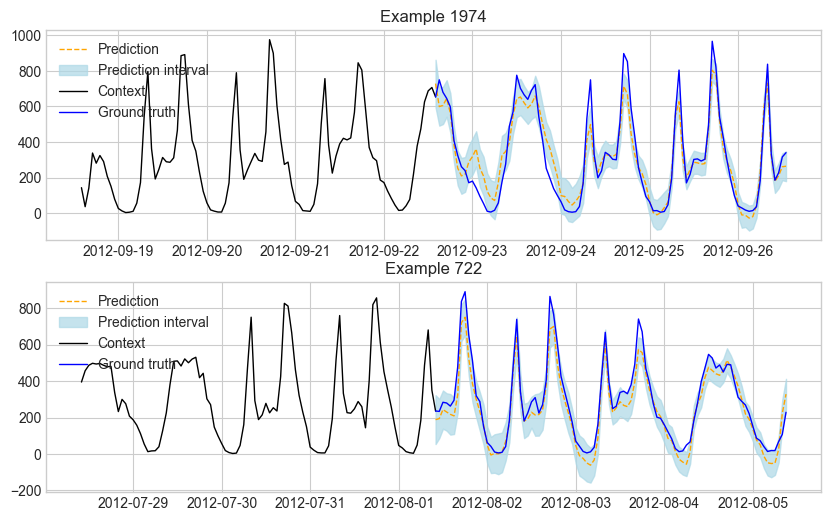

In [24]:
# plotting
plt.style.use("seaborn-v0_8-whitegrid")

indices = [1974, 722]

plot_context = 1 * prediction_length
num_plots = 2
timestamp_column = tsp.timestamp_column
freq = tsp.freq
channel = "cnt"
channel_pred = "cnt_prediction"
channel_lower = f"{channel_pred}_lower"
channel_upper = f"{channel_pred}_upper"


gt_df = test_df.copy()
gt_df = gt_df.set_index(timestamp_column)

fig, axs = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))

for i, idx in enumerate(indices):
    ts_y_hat = create_timestamps(forecast_test.loc[idx][timestamp_column], freq=freq, periods=prediction_length)

    y_hat = forecast_test.iloc[idx][channel_pred]
    y_hat_lower = forecast_test.iloc[idx][channel_lower]
    y_hat_upper = forecast_test.iloc[idx][channel_upper]

    loc = gt_df.index.get_loc(forecast_test.iloc[idx][timestamp_column])
    ts_index = gt_df.index[loc - plot_context + 1 : loc + 2]  #  + prediction_length]
    y = gt_df.loc[ts_index][channel]
    ts_y = y.index
    y = y.values

    ts_index = gt_df.index[loc + 1 : loc + 1 + prediction_length]
    y2 = gt_df.loc[ts_index][channel]
    ts_y2 = y2.index
    y2 = y2.values

    axs[i].plot(ts_y_hat, y_hat, label="Prediction", linestyle="--", color="orange", linewidth=1)
    axs[i].fill_between(
        ts_y_hat, y_hat_lower, y_hat_upper, label="Prediction interval", alpha=0.7, color="lightblue", linewidth=1
    )

    axs[i].plot(ts_y, y, label="Context", linestyle="-", color="black", linewidth=1)
    axs[i].plot(ts_y2, y2, label="Ground truth", linestyle="-", color="blue", linewidth=1)
    axs[i].set_title(f"Example {idx}")
    axs[i].legend(loc="upper left")

## Links
* Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
* Model: [TinyTimeMixer on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1)
* Dataset: [Bike Sharing Dataset on Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset)